In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import os
import glob
import pickle

In [3]:
datapd = pd.read_csv('all_coord.csv')

In [4]:
# read netcdf files and save september southern (<-40) sea ice concentration data for further calculation
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id'] 
    fpath = 'data_siconc/' + name + '.pickle'

    if os.path.exists(fpath):
        print('[o] {} exists.'.format(name))
        continue

    data_path = '/mnt/d/CMIP6/siconc_SImon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    if name == 'NorESM2-LM':
        data_path = '/mnt/d/CMIP6/siconc_SImon_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + '.nc'
    # Get the list of files matching the search pattern
    matching_files = glob.glob(data_path)    
    # Check if there are any matching files
    if matching_files:
        if pd.isna(datapd.at[i, 'xname']):
            print("[x] {} doesn't have regular grid.".format(name))
            continue
        if name == 'EC-Earth3-Veg':
            print("[ ] {}: too large.".format(name))
            continue
        ds = xr.open_mfdataset(matching_files, use_cftime=True)
    else:
        print("[x] No {} files found.".format(name))
        continue
    
    da = ds.siconc
    if 'type' in da.coords:
        da = da.reset_coords('type', drop = True)
    da_sep = da.isel(time=(da.time.dt.month == 9))

    southlat = -40

    if pd.isna(datapd.at[i, 'latname']):
        da_south = da_sep.sel({datapd.at[i, 'yname']:slice(-90, southlat)})
    else:
        if name == 'NESM3':
            da_lat = da_sep['lat'].load()
        else:
            da_lat = da_sep[datapd.at[i, 'latname']].load()
        da_south = da_sep.where(da_lat < southlat, drop=True)

    da_save = da_south.load()
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
        print("[*] {}: done.".format(name))

[o] BCC-CSM2-MR exists.
[o] BCC-ESM1 exists.
[o] CAMS-CSM1-0 exists.
[o] ACCESS-ESM1-5 exists.
[o] ACCESS-CM2 exists.
[o] GFDL-CM4 exists.
[o] GFDL-ESM4 exists.
[o] KIOST-ESM exists.
[o] NESM3 exists.
[o] CanESM5 exists.
[o] CanESM5-1 exists.
[o] CanESM5-CanOE exists.
[o] CMCC-CM2-SR5 exists.
[o] CMCC-ESM2 exists.
[o] EC-Earth3 exists.
[o] EC-Earth3-CC exists.
[o] EC-Earth3-LR exists.
[o] EC-Earth3-Veg exists.
[o] EC-Earth3-Veg-LR exists.
[o] EC-Earth3-AerChem exists.
[o] CNRM-CM6-1 exists.
[o] CNRM-CM6-1-HR exists.
[o] CNRM-ESM2-1 exists.
[o] HadGEM3-GC31-LL exists.
[o] HadGEM3-GC31-MM exists.
[o] UKESM1-0-LL exists.
[o] UKESM1-1-LL exists.
[o] IPSL-CM5A2-INCA exists.
[o] IPSL-CM6A-LR exists.
[o] IPSL-CM6A-MR1 exists.
[o] MIROC6 exists.
[o] MIROC-ES2L exists.
[o] MIROC-ES2H exists.
[o] MRI-ESM2-0 exists.
[o] FGOALS-g3 exists.
[o] CAS-ESM2-0 exists.
[o] CIESM exists.
[o] TaiESM1 exists.
[o] CESM2 exists.
[o] CESM2-FV2 exists.
[o] CESM2-WACCM exists.
[o] CESM2-WACCM-FV2 exists.
[o] SAM0

In [5]:
# for EC-Earth3-Veg only
i = datapd.loc[datapd['source_id'] == 'EC-Earth3-Veg'].index[0]

fpath = 'data_siconc/EC-Earth3-Veg.pickle'
if os.path.exists(fpath):
    print('[o] EC-Earth3-Veg exists.')
else:
    data_path = '/mnt/d/CMIP6/siconc_SImon_EC-Earth3-Veg_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    # Get the list of files matching the search pattern
    matching_files = glob.glob(data_path)
    
    for t in range(len(matching_files)):
        ds = xr.open_mfdataset(matching_files[t], use_cftime=True)
        da = ds.siconc

        if 'type' in da.coords:
            da = da.reset_coords('type', drop = True)
            
        da_sep = da.isel(time=(da.time.dt.month == 9))
        
        southlat = -40
        
        if pd.isna(datapd.at[i, 'latname']):
            da_south = da_sep.sel({datapd.at[i, 'yname']:slice(-90, southlat)})
        else:
            da_lat = da_sep[datapd.at[i, 'latname']].load()
            da_south = da_sep.where(da_lat < southlat, drop=True)
        
        if t == 0:
            da_save = da_south.load()
        else:
            da_save0 = da_south.load()
            da_save = xr.concat([da_save, da_save0], dim="time")
            print(matching_files[t])
    
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
        print("[*] EC-Earth3-Veg: done.")

[o] EC-Earth3-Veg exists.


In [6]:
# For area data: read netcdf files and save southern (<-40) data for further calculation
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    fpath = 'data_area/' + name + '.pickle'

    if os.path.exists(fpath):
        print('[o] {} exists.'.format(name))
        continue

    if name == 'NESM3' or name == 'NorESM2-MM' or name == 'KIOST-ESM':
        print('[ ] {}: grid error.'.format(name))
        continue

    data_path = 'data_areacello/areacello_Ofx_' + name + '_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    if name == 'GISS-E2-2-H':
        data_path = 'data_areacello/areacello_Ofx_GISS-E2-1-H_piControl_' + datapd.at[i, 'member_id'] + '*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
    elif name == 'UKESM1-1-LL':
        data_path = 'data_areacello/areacello_Ofx_UKESM1-0-LL_piControl_' + '*' + '.nc'
    # Get the list of files matching the search pattern
    matching_files = glob.glob(data_path)
    
    # Check if there are any matching files
    if matching_files:
        if len(matching_files)>1:
            print("[ ] {}: more than 1 file.".format(name))
            continue
        if pd.isna(datapd.at[i, 'xname']):
            print("[x] {} doesn't have regular grid.".format(name))
            continue
        ds = xr.open_mfdataset(matching_files)
    else:
        data_path = 'data_areacello/areacello_Ofx_' + name + '_*' + datapd.at[i, 'grid_label'] + '*' + '.nc'
        if name == 'NorESM2-LM':
            data_path = 'data_areacello/areacello_Ofx_' + name + '_*.nc'
        matching_files = glob.glob(data_path)
        if matching_files:
            if len(matching_files)>1:
                print("[ ] {}: more than 1 file.".format(name))
                continue
            if pd.isna(datapd.at[i, 'xname']):
                print("[x] {} doesn't have regular grid.".format(name))
                continue
            ds = xr.open_mfdataset(matching_files)
        else:
            print("[ ] No {} files found.".format(name))
            continue
        
    da = ds.areacello
    if name == 'CMCC-CM2-SR5'  or name == 'CMCC-ESM2':
        da = ds.areacello.isel(j=slice(1, len(ds.j)-1)).isel(i=slice(0,len(ds.i)-1))
        
    if 'type' in da.coords:
        da = da.reset_coords('type', drop = True)
    
    if 'time' in da.coords:
        print("[ ] {}: multiply time.".format(name))
        continue
        # da_sep = da.isel(time=(da.time.dt.month == 9))

    southlat = -40

    if pd.isna(datapd.at[i, 'latname']):
        da_south = da.sel({datapd.at[i, 'yname']:slice(-90, southlat)})
    else:
        if name == 'CAS-ESM2-0':
            da_south = da.sel(lat = slice(-90, southlat))
        else:
            if name == 'NESM3':
                da_lat = da['lat'].load()     
            else:
                da_lat = da[datapd.at[i, 'latname']].load()
            da_south = da.where(da_lat < southlat, drop=True)

    da_save = da_south.load()
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
        print("[*] {}: done.".format(name))

[o] BCC-CSM2-MR exists.
[o] BCC-ESM1 exists.
[o] CAMS-CSM1-0 exists.
[o] ACCESS-ESM1-5 exists.
[o] ACCESS-CM2 exists.
[o] GFDL-CM4 exists.
[o] GFDL-ESM4 exists.
[o] KIOST-ESM exists.
[o] NESM3 exists.
[o] CanESM5 exists.
[o] CanESM5-1 exists.
[o] CanESM5-CanOE exists.
[o] CMCC-CM2-SR5 exists.
[o] CMCC-ESM2 exists.
[o] EC-Earth3 exists.
[o] EC-Earth3-CC exists.
[o] EC-Earth3-LR exists.
[o] EC-Earth3-Veg exists.
[o] EC-Earth3-Veg-LR exists.
[o] EC-Earth3-AerChem exists.
[o] CNRM-CM6-1 exists.
[o] CNRM-CM6-1-HR exists.
[o] CNRM-ESM2-1 exists.
[o] HadGEM3-GC31-LL exists.
[o] HadGEM3-GC31-MM exists.
[o] UKESM1-0-LL exists.
[o] UKESM1-1-LL exists.
[o] IPSL-CM5A2-INCA exists.
[o] IPSL-CM6A-LR exists.
[o] IPSL-CM6A-MR1 exists.
[o] MIROC6 exists.
[o] MIROC-ES2L exists.
[o] MIROC-ES2H exists.
[o] MRI-ESM2-0 exists.
[o] FGOALS-g3 exists.
[o] CAS-ESM2-0 exists.
[o] CIESM exists.
[o] TaiESM1 exists.
[o] CESM2 exists.
[o] CESM2-FV2 exists.
[o] CESM2-WACCM exists.
[o] CESM2-WACCM-FV2 exists.
[o] SAM0

In [7]:
### for NESM3
fpath = 'data_area/NESM3.pickle'
if os.path.exists(fpath):
    print('[o] NESM3 exists.')
else:
    ds = xr.open_dataset('data_areacello/areacelli_Ofx_NESM3_lig127k_r1i1p1f1_gn.nc')
    dsi = xr.open_dataset('/mnt/d/CMIP6/siconc_SImon_NESM3_piControl_r1i1p1f1_gn_100001-109912.nc')
    
    da0 = ds.areacelli
    da = da0.assign_coords(lon = dsi.lon, lat = dsi.lat)
    
    southlat = -40
    da_lat = da['lat'].load()
    da_south = da.where(da_lat < southlat, drop=True)
    da_save = da_south.load()
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
        print("[o] NESM3: done.")

[o] NESM3 exists.


In [8]:
### for NorESM2-MM
fpath = 'data_area/NorESM2-MM.pickle'
if os.path.exists(fpath):
    print('[o] NorESM2-MM exists.')
else:
    ds = xr.open_dataset('data_areacello/areacello_Ofx_NorESM2-MM_piControl_r1i1p1f1_gn.nc')
    dsi = xr.open_dataset('/mnt/d/CMIP6/siconc_SImon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc')
    
    da0 = ds.areacello.isel(j=slice(0, len(ds.j)-1))

    da = da0.assign_coords(lon = dsi.longitude, lat = dsi.latitude)
    
    southlat = -40
    da_lat = da['latitude'].load()
    da_south = da.where(da_lat < southlat, drop=True)
    da_save = da_south.load()
    with open(fpath, 'wb') as wf:
        pickle.dump(da_save, wf, pickle.HIGHEST_PROTOCOL)
        print("[o] NorESM2-MM: done.")


[o] NorESM2-MM exists.


In [28]:
ds = xr.open_dataset('data_areacello/areacello_Ofx_NorESM2-MM_piControl_r1i1p1f1_gn.nc')
dsi = xr.open_dataset('/mnt/d/CMIP6/siconc_SImon_NorESM2-MM_piControl_r1i1p1f1_gn_120001-120912.nc')

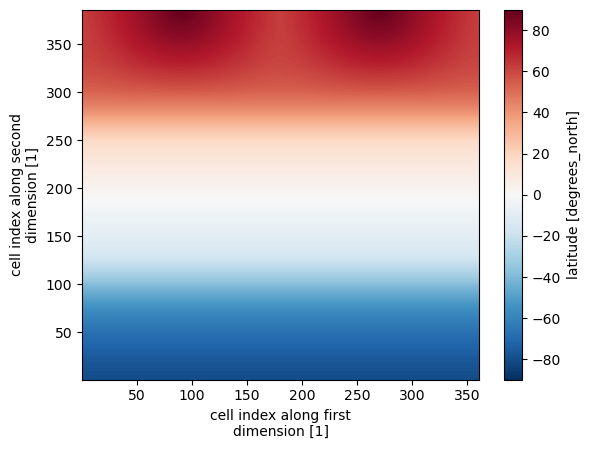

In [36]:
ds.latitude.plot()

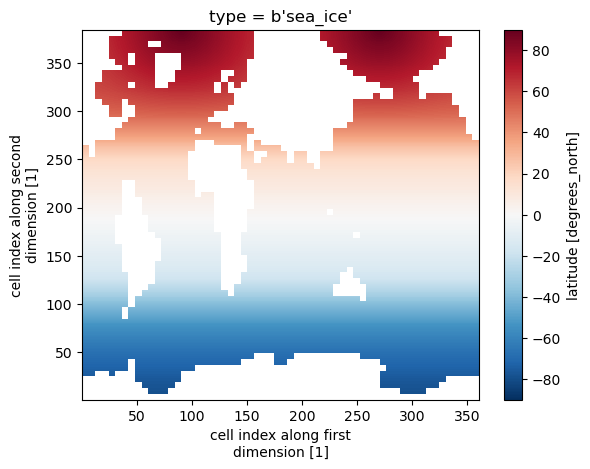

In [35]:
dsi.latitude.plot()

In [9]:
from scipy import ndimage
from skimage.segmentation import flood_fill

In [10]:
def detect_polynya(daice, daarea, ice_threshold, area_threshold):
    # for structure-grid data
    s = ndimage.generate_binary_structure(2,2)
    da_masked = xr.DataArray(np.nan*np.empty_like(daice), dims = daice.dims, coords = daice.coords)
    for year in daice.time:
        ice0 = daice.sel(time = year)
        icenew = ice0 <= ice_threshold
        ice = xr.where(np.isnan(ice0), True, icenew)   # get rid of "coastal polynya" 
        labeled_image, num_features = ndimage.label(ice, structure = s)
        if num_features < 2:
            continue
        mask = np.zeros_like(labeled_image)
        for i in range(1, num_features+1):
            area = daarea.where(labeled_image == i).sum()/1000000  # m2 -> km2
            if (area > area_threshold[0]) and (area < area_threshold[1]):  # the area of ose 'polynya' within the sea ice extent is small
                mask[labeled_image == i] = 1
        da_masked.loc[year] = xr.where(mask, ice0, np.nan)
    return da_masked #.mean('time'), da_masked.count('time')

In [11]:
def newxy_fmissingxy(dx, dy):
    newx0 = dx[~np.isnan(dx).any(axis=1)][0]
    newy0 = dy[:, ~np.isnan(dy).any(axis=0)][:,0]
    newx, newy = np.meshgrid(newx0, newy0)
    x = np.where(np.isnan(dx), newx, dx)
    y = np.where(np.isnan(dy), newy, dy)
    return x, y

In [22]:
ice_thresholds = [75]
area_threshold = [10000, 1000000]

for ice_threshold in ice_thresholds:
    for j in range(0, len(datapd)):
        name = datapd.at[j, 'source_id']
        icepath = 'data_siconc/' + name + '.pickle'
        areapath = 'data_area/' + name + '.pickle'
        
        pltd_name = 'data_polynya/' + name + '_'+ str(ice_threshold) +'.pickle'
        if os.path.exists(pltd_name):
            print('[o] {} exists.'.format(name))
            continue
        if not os.path.exists(icepath):
            print('[ ] {}: No ice data.'.format(name))
            continue
        if not os.path.exists(areapath):
            print('[ ] {}: No area data.'.format(name))
            continue
        
        with open(icepath, 'rb') as f:
            icedata = pickle.load(f)
        with open(areapath, 'rb') as f:
            areadata = pickle.load(f)
        
        if name == 'E3SM-2-0':
            icedata = xr.where(icedata.lat > icedata.isel(lat = icedata.argmax('lat')).lat, icedata.fillna(0), icedata)
            
        ice_max = icedata.max('time')
        ice_masked = detect_polynya(icedata, areadata, ice_threshold, area_threshold)
        polynya_count = ice_masked.count('time')
        polynya_freq = polynya_count.where(polynya_count>0) / len(ice_masked.time)
        
        if name == 'NESM3':
            pltx = icedata['lon']
            plty = icedata['lat']
        else:
            if pd.isna(datapd.at[j, 'latname']):
                pltx0 = icedata[datapd.at[j, 'xname']]
                plty0 = icedata[datapd.at[j, 'yname']]
                pltx, plty = np.meshgrid(pltx0, plty0)
            else:
                pltx = icedata[datapd.at[j, 'lonname']]
                plty = icedata[datapd.at[j, 'latname']]

        if len(np.shape(pltx)) > 2:
            pltx = pltx.isel(time = 0)
            plty = plty.isel(time = 0)
        
        if np.isnan(pltx).any() or np.isnan(plty).any():
            pltx, plty = newxy_fmissingxy(pltx, plty)
        elif (pltx>500).any() or (plty>500).any():
            pltx = pltx.where(pltx<500)
            plty = plty.where(plty<500)
            pltx, plty = newxy_fmissingxy(pltx, plty)
        # elif name == "GISS-E2-2-H" or name == "GISS-E2-1-H" or name == "INM-CM4-8":
        #     pltd = flood_fill(pltd.values, (0, 0), 100)

        polynya_dict = {'ice_max':ice_max, 'polynya_freq':polynya_freq,'pltx':pltx, 'plty':plty}

        with open(pltd_name, 'wb') as sf:
            pickle.dump(polynya_dict, sf, pickle.HIGHEST_PROTOCOL)
            print("[o] {}: done.".format(name))

[o] BCC-CSM2-MR exists.
[o] BCC-ESM1 exists.
[o] CAMS-CSM1-0 exists.
[o] ACCESS-ESM1-5 exists.
[o] ACCESS-CM2 exists.
[o] GFDL-CM4 exists.
[o] GFDL-ESM4 exists.
[x] KIOST-ESM: No area data.
[o] NESM3 exists.
[o] CanESM5 exists.
[o] CanESM5-1 exists.
[o] CanESM5-CanOE exists.
[o] CMCC-CM2-SR5 exists.
[o] CMCC-ESM2 exists.
[o] EC-Earth3 exists.
[o] EC-Earth3-CC exists.
[o] EC-Earth3-LR exists.
[o] EC-Earth3-Veg exists.
[o] EC-Earth3-Veg-LR exists.
[o] EC-Earth3-AerChem exists.
[o] CNRM-CM6-1 exists.
[o] CNRM-CM6-1-HR exists.
[o] CNRM-ESM2-1 exists.
[o] HadGEM3-GC31-LL exists.
[o] HadGEM3-GC31-MM exists.
[o] UKESM1-0-LL exists.
[o] UKESM1-1-LL: done.
[o] IPSL-CM5A2-INCA exists.
[o] IPSL-CM6A-LR exists.
[o] IPSL-CM6A-MR1: done.
[o] MIROC6 exists.
[o] MIROC-ES2L exists.
[o] MIROC-ES2H: done.
[o] MRI-ESM2-0 exists.
[o] FGOALS-g3 exists.
[o] CAS-ESM2-0: done.
[o] CIESM exists.
[o] TaiESM1 exists.
[o] CESM2 exists.
[o] CESM2-FV2 exists.
[o] CESM2-WACCM exists.
[o] CESM2-WACCM-FV2 exists.
[o] S

ValueError: operands could not be broadcast together with shapes (89,360) (97,360) () 

In [23]:
name

'NorESM2-LM'

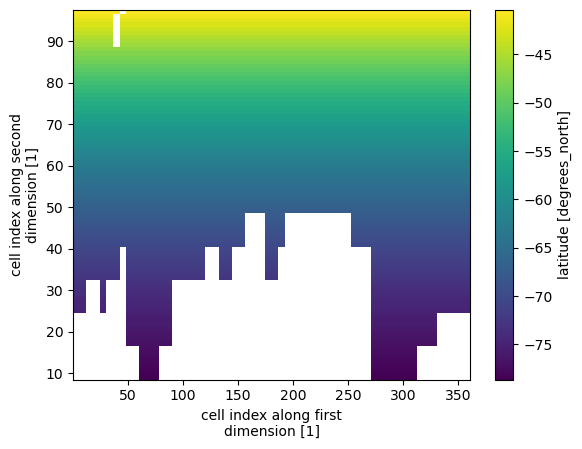

In [27]:
icedata.latitude.where(icedata.latitude<360).plot()

In [25]:
areadata

<xarray.DataArray 'areacello' (j: 97, i: 360)> Size: 140kB
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [6.846346e+09, 6.846346e+09, 6.846346e+09, ..., 6.846346e+09,
        6.846346e+09, 6.846346e+09],
       [7.006689e+09, 7.006689e+09, 7.006689e+09, ..., 7.006689e+09,
        7.006689e+09, 7.006689e+09],
       [7.168311e+09, 7.168311e+09, 7.168311e+09, ..., 7.168311e+09,
        7.168311e+09, 7.168311e+09]], dtype=float32)
Coordinates:
  * j          (j) int32 388B 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96 97
  * i          (i) int32 1kB 1 2 3 4 5 6 7 8 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 279kB -80.11 -80.11 -80.11 ... -40.41 -40.41
    longitude  (j, i) float64 279kB 250.5 251.5 252.5 ... 247.5 248.5 249.5
Attributes:
    standard_name:  cell_area
    long_name:      Grid-Cell Area for Ocean Variables
    comment:        Horizontal area of ocean grid cells
    units:          m2
    original_name:  parea
    cell_methods:   area: sum
    history:        2019-11-08T08:17:36Z altered by CMOR: Converted type from...

In [18]:
icedata = xr.where(icedata.lat > icedata.isel(lat = icedata.argmax('lat')).lat, icedata.fillna(0), icedata)

In [19]:
icedata

<xarray.DataArray (lat: 50, time: 500, lon: 360)> Size: 36MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 400B -89.5 -88.5 -87.5 -86.5 ... -42.5 -41.5 -40.5
  * time     (time) object 4kB 0001-09-16 00:00:00 ... 0500-09-16 00:00:00
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

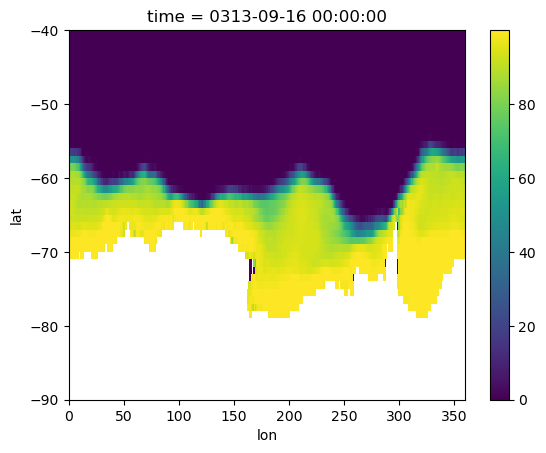

In [51]:
test.isel(time = 312).plot()

! Note (why some models are not chosen)

'NorESM1-F': no temp&salt data, no mlotst on CMIP6 site

'INM-CM5-0': have temp but no salt data(only global salt) and no mlotst data

'AWI-CM-1-1-MR': no monthly siconc data

'FIO-ESM-2-0': no salt data

--

other note

'IPSL-CM6A-MR1': have area data in thetao


In [14]:
xr.open_dataset('/mnt/d/CMIP6/siconc_SImon_IPSL-CM6A-MR1_piControl_r1i1p1f1_gn_187501-189912.nc')

<xarray.Dataset> Size: 150MB
Dimensions:         (y: 332, x: 362, nvertex: 4, time: 300, axis_nbounds: 2)
Coordinates:
    nav_lat         (y, x) float32 481kB ...
    nav_lon         (y, x) float32 481kB ...
    type            |S255 255B ...
  * time            (time) datetime64[ns] 2kB 1875-01-16T12:00:00 ... 1899-12...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon  (y, x, nvertex) float32 2MB ...
    bounds_nav_lat  (y, x, nvertex) float32 2MB ...
    area            (y, x) float32 481kB ...
    time_bounds     (time, axis_nbounds) datetime64[ns] 5kB ...
    siconc          (time, y, x) float32 144MB ...
Attributes: (12/50)
    name:                   /ccc/work/cont003/gencmip6/p86fair/IGCM_OUT/IPSLC...
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2021-04-18T01:32:09Z
    tracking_id:            hdl:21.14100/e22d7d97-b284-42f3-9941-c460f9c749e3
    description:            DECK: control
    title:                  IPSL-CM6A-MR1 model output prepared for CMIP6 / C...
    ...                     ...
    EXPID:                  piControl
    CMIP6_CV_version:       cv=6.2.15.1
    dr2xml_md5sum:          b6a4ad73a1532e0d6b26eac064e3c807
    model_version:          6.2.2
    license:                CMIP6 model data produced by IPSL is licensed und...
    parent_activity_id:     CMIP

In [5]:
dd = []
with open("a.txt") as f:
    for line in f:
        l = line.split('_')
        dd.append(l[2])

In [6]:
al = []
for i in range(0, len(datapd)):
    al.append(datapd.at[i, 'source_id'])


In [9]:
l1

{'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-1',
 'CanESM5-CanOE',
 'E3SM-1-0',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'E3SM-2-0',
 'E3SM-2-0-NARRM',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-LR',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-H',
 'GISS-E2-2-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'ICON-ESM-LR',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'IPSL-CM6A-MR1',
 'KIOST-ESM',
 'MIROC-ES2H',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM1-F',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL',
 'UKESM1-1-LL'}

In [7]:
l1 = set(dd)

In [10]:
b = [x for x in l1 if x not in al]
b

['IPSL-CM6A-MR1', 'NorESM1-F', 'INM-CM5-0', 'NorESM2-LM']

In [11]:
test = xr.open_dataset("/mnt/d/CMIP6/siconc_SImon_CAS-ESM2-0_piControl_r1i1p1f1_gn_020001-029912.nc")

In [14]:
ds

<xarray.Dataset> Size: 296kB
Dimensions:    (lat: 196, bnds: 2, lon: 360)
Coordinates:
  * lat        (lat) float64 2kB -78.0 -77.0 -76.0 -75.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(196, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 6kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    areacello  (lat, lon) float32 282kB dask.array<chunksize=(196, 360), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Spin-up documentation
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                He Zhang(zhanghe@mail.iap.ac.cn)
    ...                     ...
    title:                  CAS-ESM2-0 output prepared for CMIP6
    tracking_id:            hdl:21.14100/535daa20-6062-405e-a166-8bb8fe58047a
    variable_id:            areacello
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Chinese Academy of S...
    cmor_version:           3.5.0

In [17]:
test.siconc.latitude.load()

<xarray.DataArray 'latitude' (j: 196, i: 360)> Size: 564kB
array([[-78.0004425 , -78.0004425 , -78.0004425 , ..., -78.0004425 ,
        -78.0004425 , -78.0004425 ],
       [-77.00048065, -77.00048065, -77.00048065, ..., -77.00048065,
        -77.00048065, -77.00048065],
       [-76.00051117, -76.00051117, -76.00051117, ..., -76.00051117,
        -76.00051117, -76.00051117],
       ...,
       [ 88.00007629,  88.00007629,  88.00007629, ...,  88.00007629,
         88.00007629,  88.00007629],
       [ 89.00003815,  89.00003815,  89.00003815, ...,  89.00003815,
         89.00003815,  89.00003815],
       [ 90.        ,  90.        ,  90.        , ...,  90.        ,
         90.        ,  90.        ]])
Coordinates:
  * j          (j) int32 784B 0 1 2 3 4 5 6 7 ... 189 190 191 192 193 194 195
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 564kB -78.0 -78.0 -78.0 -78.0 ... 90.0 90.0 90.0
    longitude  (j, i) float64 564kB 1.0 2.0 3.0 4.0 ... 177.0 178.0 179.0 180.0
    type       |S7 7B b'sea_ice'
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.path as mpath
import cmocean
import seaborn as sns

In [14]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

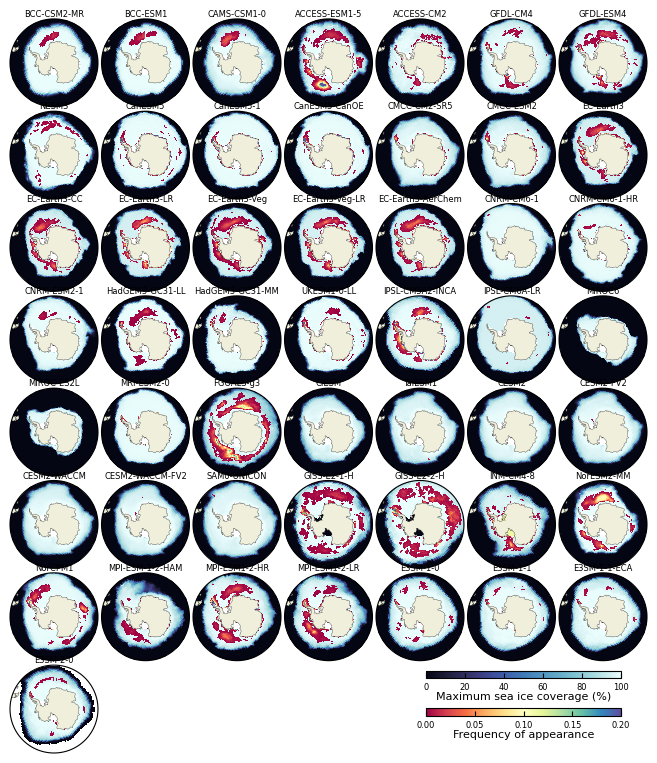

In [16]:
fig = plt.figure(figsize=(6.5,7.5))

n = 1
ice_threshold = 75

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    pltd_name = 'data_polynya/' + datapd.at[i, 'source_id']  + '_'+ str(ice_threshold) +'.pickle'

    if os.path.exists(pltd_name):
        with open(pltd_name, 'rb') as f:
            pltd_dict = pickle.load(f)
        
        ax = fig.add_subplot(8, 7, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        # fig.subplots_adjust(wspace=0.04, hspace=0.12)
        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

        pltx = pltd_dict['pltx']
        plty = pltd_dict['plty']
        ice_max = pltd_dict['ice_max']
        polynya_freq = pltd_dict['polynya_freq']

        # gl = ax.gridlines(
        #     xlocs = np.arange(-180,180,90), 
        #     ylocs = np.arange(-90,90,20),
        #     draw_labels=False, y_inline=True)
            
        ax.set_title('{}'.format(datapd.at[i, 'source_id']), fontsize=6, pad=-0.5)
        
        im = ax.pcolormesh(pltx, plty, ice_max, 
                           transform=ccrs.PlateCarree(), 
                           vmin=0, vmax=100, 
                           cmap=cmocean.cm.ice)
        
        # newcmap = cmocean.tools.crop_by_percent(cmocean.cm.speed_r, 50, which='min', N=None)
        im2 = ax.pcolormesh(pltx, plty, polynya_freq, 
                            transform=ccrs.PlateCarree(), 
                            vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
        ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
        ax.set_boundary(circle, transform=ax.transAxes)
        
        n = n+1       

        # if n > 3:
        #     break 

cbar_ax1 = fig.add_axes([0.65, 0.11, 0.30, 0.01])
cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
cbar1.ax.tick_params(labelsize=6,direction='in')

cbar_ax2 = fig.add_axes([0.65, 0.06, 0.30, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6,direction='in')

# fig.savefig('Polynya_Multi.png', dpi = 300)


In [93]:
datapd.at[i, 'source_id']

'CIESM'

In [51]:
def find_nonanx(dx):
    for i in range(0, np.shape(dx)[0]):
        if ~np.isnan(dx[i,:]).any():
            break
    return dx[i,:]

def find_nonany(dy):
    for i in range(0, np.shape(dy)[1]):
        if ~np.isnan(dy[:,i]).any():
            break
    return dy[:,i]
